In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
from pickle import FALSE
import matplotlib.ticker as ticker
from bioinfokit.analys import stat
#from pandas_profiling import ProfileReport

# Graphics

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Preprocessing 

import missingno as msno
from fancyimpute import IterativeImputer as MICE
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer

# Model Selection & evaluation

from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, BayesianRidge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from yellowbrick.regressor import ResidualsPlot

#pio.renderers.default = 'vscode'
pio.templates.default = 'plotly'
pio.renderers.default = "notebook"

# Part 2 : Machine Learning

In [2]:
# Data import 
data = pd.read_csv('preprocessed.csv')

# Overview 
len0 = len(data)
data.describe(include='all')

,Store,Weekly_Sales,Holiday_Flag,Temperature,Unemployment,year,month,week,CPI_R
count,122.000000,1.220000e+02,113,112.000000,111.000000,113.000000,113.000000,113.000000,122.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Regular,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,106,NaN,NaN,NaN,NaN,NaN,NaN
mean,10.073770,1.269095e+06,NaN,60.376250,7.429018,2010.831858,6.734513,3.017699,1.008197
std,6.243235,6.650574e+05,NaN,18.082773,0.985674,0.822699,3.380664,1.253440,0.857595
min,1.000000,2.689290e+05,NaN,18.790000,5.143000,2010.000000,1.000000,1.000000,0.000000
25%,4.000000,5.774276e+05,NaN,45.120000,6.716000,2010.000000,4.000000,2.000000,0.000000
50%,9.000000,1.412706e+06,NaN,61.450000,7.470000,2011.000000,6.000000,3.000000,1.000000
75%,16.000000,1.826659e+06,NaN,75.375000,8.102500,2012.000000,10.000000,4.000000,2.000000


# 1. Preprocessings to be planned with scikit-learn

First of all, we will separate the target variable (Y) and the explanatory variables (X). Among the explanatory variables, we also need to identify which columns contain categorical variables and which columns contain numerical variables, as they will be treated differently.

 - Categorical variables : Store, Holiday_Flag, CPI_R, Year, Month, Week
 - Numerical variables : Temperature, Unemployment

## 1.1. Target variable (Y) vs. Explanatory variables (X)

In [3]:
Y = data['Weekly_Sales'].values

In [4]:
X = data.drop(['Weekly_Sales'], axis = 1)
X.head()

,Store,Holiday_Flag,Temperature,Unemployment,year,month,week,CPI_R
0,6.0,NaN,59.61,6.858,2011.0,2.0,3.0,2
1,13.0,Regular,42.38,7.470,2011.0,3.0,4.0,0
2,6.0,Regular,78.89,7.092,2010.0,5.0,5.0,1
3,4.0,Regular,NaN,7.896,2010.0,5.0,5.0,0
4,15.0,Regular,69.80,7.658,2011.0,3.0,1.0,0


## 1.2. Split Train - Test

Then, we split the entire dataset into two datasets, one for training our model, one for testing it. We used 70% of the dataset for training and 30% for testing because of the limited size of the original dataset and the high number of explanatory variables after preprocessing. 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

## 1.3. Dealing with missing values

Linear regression are not automatically dealing with missing values, and it needs a complete dataset as in input. 

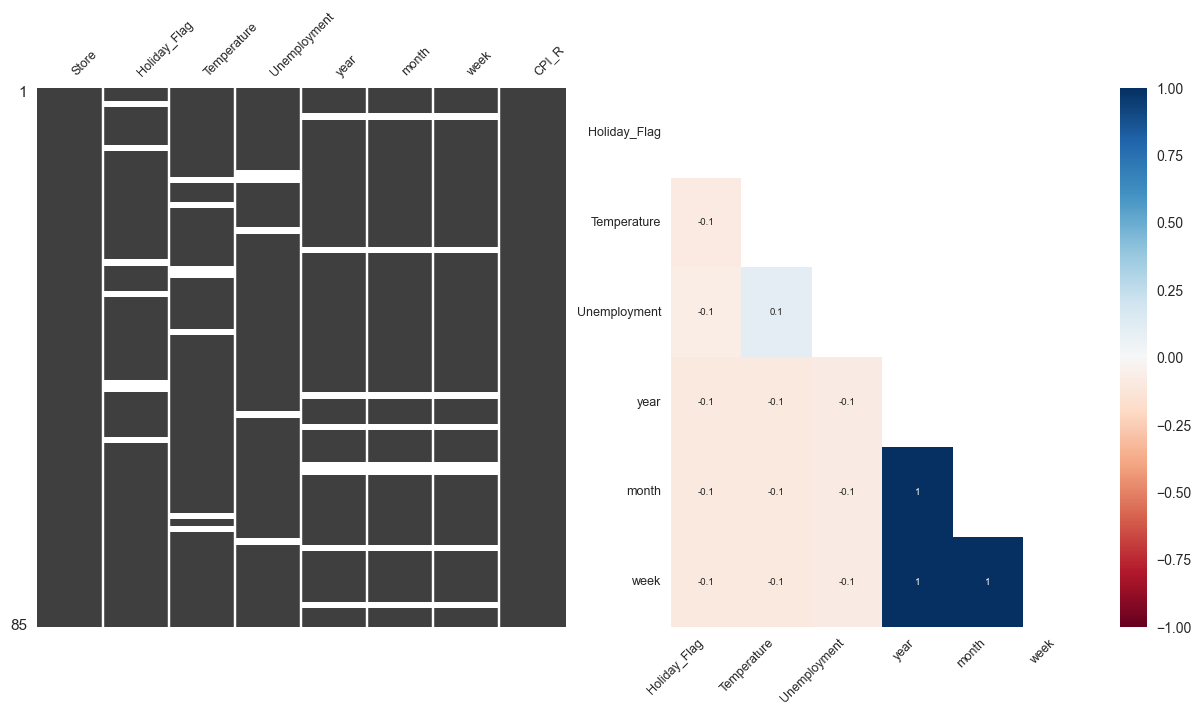

In [6]:
import missingno as msno

fig, axarr = plt.subplots(ncols = 2, figsize = (15,7))
msno.matrix(X_train, ax = axarr[0], fontsize = 9);
msno.heatmap(X_train, ax = axarr[1], fontsize = 9);

In [7]:
# Number of missing values per variable
X_train.isnull().sum()

Store           0
Holiday_Flag    7
Temperature     7
Unemployment    5
year            8
month           8
week            8
CPI_R           0
dtype: int64

Data seems to be missing at random, allowing us to procede to an imputation (replacement of the missing value by another value derived from the data, could be the mean, the median or a value computed with a more complex algorithm). We just observe a strong correlation of missingness between the 3 variables derived from date (date missing, the 3 variables are missing). 

In [8]:
# Categorical variables are already dummy coded, let's scale the continuous ones
# Categorical variables are dummy coded and continuous ones are scaled
categorical = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
        ('encoder', OneHotEncoder(drop='first'))
    ]
)
continu = Pipeline(
    steps = [
        ('scaler', StandardScaler(with_mean=False))
    ]
)

pipelines = [
    ('continu', continu, [2,3]),
    ('categorical', categorical, [0,1,4,5,6,7])
]

pips = ColumnTransformer(
    transformers=pipelines
)

X_train = pips.fit_transform(X_train)
X_test = pips.transform(X_test)

In [9]:
# Imputing the missing values with MICE
# https://www.numpyninja.com/post/mice-algorithm-to-impute-missing-values-in-a-dataset
mice_impute = MICE()
X_train = mice_impute.fit_transform(X_train.toarray())
X_test = mice_impute.transform(X_test.toarray())

# 2. Baseline model - Linear regression

## 2.1. Fit the Baseline Model

In [10]:
model_base = LinearRegression()
model_base.fit(X_train, Y_train)
Y_train_pred = model_base.predict(X_train)
Y_test_pred = model_base.predict(X_test)

## 2.2. Baseline Model examination

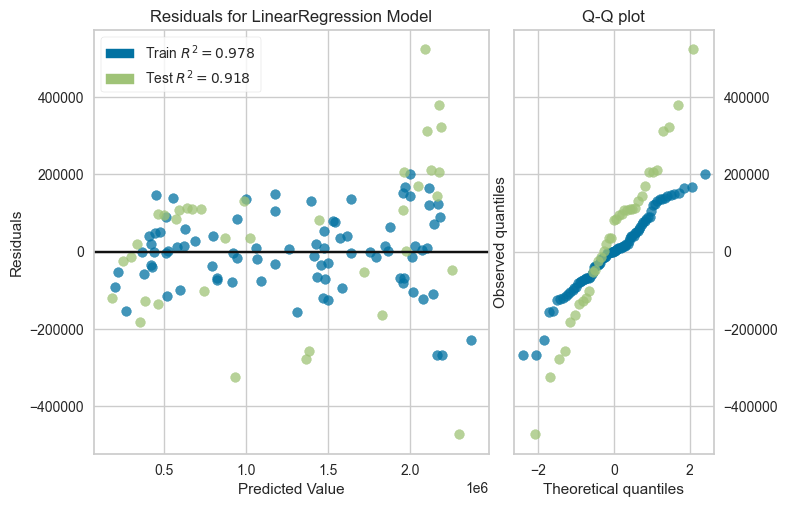

In [11]:
visualizer = ResidualsPlot(model_base, hist = False, qqplot = True)
visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
visualizer.show();                # Finalize and render the figure

The baseline model (Train) seems adapted as residuals are relatively well distributed regarding the non normality of the Target variable. 

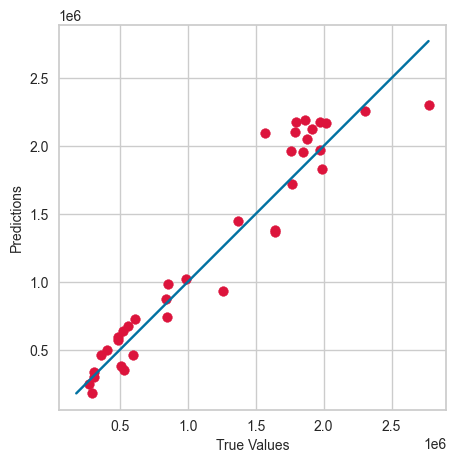

In [12]:
# Visualize the model
plt.figure(figsize = (5, 5))
plt.scatter(Y_test, Y_test_pred, c = 'crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(Y_test_pred), max(Y_test))
p2 = min(min(Y_test_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 10)
plt.ylabel('Predictions', fontsize = 10)
plt.axis('equal')
plt.show()

The prediction of the Test data seems to be well adjusted with more error / residuals for the highest values of Weekly Sales.

## 2.3. Performances

In [13]:
print("R2 Score Train : ", round(r2_score(Y_train, Y_train_pred),2))
print("R2 Score Test : ", round(r2_score(Y_test, Y_test_pred),2))
print("")

ntrain = len(Y_train)
ntest = len(Y_test)
pTrain = X_train.shape[1]
pTest = X_test.shape[1]

r2train = r2_score(Y_train, Y_train_pred)
Adj_r2train = 1-((1-r2train)*(ntrain-1)/(ntrain-pTrain-1))

r2test = r2_score(Y_test, Y_test_pred)
Adj_r2test = 1-((1-r2test)*(ntest-1)/(ntest-pTest-1))

print("Adjusted R2 score Train : ", round(Adj_r2train, 2))
print("Adjusted R2 score Test : ", round(Adj_r2test, 2))
print("")

print("MAE Train : ", round(mean_absolute_error(Y_train, Y_train_pred),2))
print("MAE Test : ", round(mean_absolute_error(Y_test, Y_test_pred),2))
print("")

print("RMSE Train : ", round(np.sqrt(mean_squared_error(Y_train, Y_train_pred)),2))
print("RMSE Test : ", round(np.sqrt(mean_squared_error(Y_test, Y_test_pred)),2))

R2 Score Train :  0.98
R2 Score Test :  0.92

Adjusted R2 score Train :  0.96
Adjusted R2 score Test :  1.74

MAE Train :  73077.81
MAE Test :  159493.29

RMSE Train :  95464.03
RMSE Test :  201816.06


The R² scores indicate very good performance of the model, in the train and in the test samples. We are almost explaining 100% of the variance of the train sample. These amazing performances may indicate that we are over-fitting the data (because we include a lot of explanatory variables for too few observations), however, the model keeps doing great in the test phase showing generalization abilities. 

The adjusted R² score is built to take into account the model parcimony - simplicity but its use is compromised here because of the test sample size which is less than the number of parameters estimated in the regression model. 

MAE & RMSE give insights regarding the adjustement between the model and the data and indicate that the "accuracy" of the predictions in absolute terms. Here we can see that the error of the model increases dramatically when we are in the test sample.  

The model has a good quality in itself but considering the number of parameters and the sample size, we have to try to simplify the model in itself. 

## 2.4. Interpretation

In [14]:
coefs = pd.DataFrame(
    model_base.coef_,
    columns=["Coefficients"],
    index=pips.get_feature_names_out(),
)

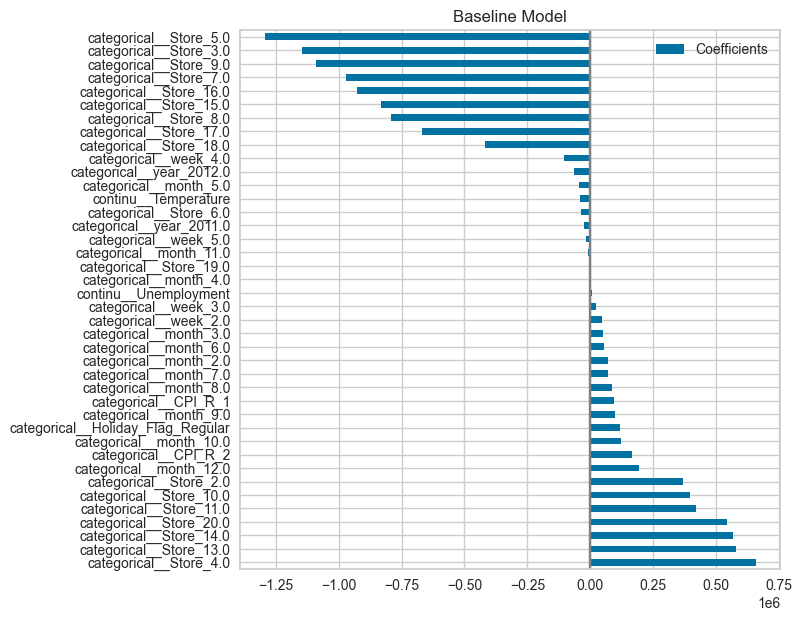

In [15]:
coefs.sort_values(by = 'Coefficients', ascending = False).plot(kind="barh", figsize = (9, 7))
plt.title("Baseline Model")
plt.axvline(x = 0, color = ".5")
plt.subplots_adjust(left = 0.3)

The examination of the model coefficients shows a massive effect of the variable STORE (in + as in -), in accordance with what we observed during the EDA. 

# 3. Fight overfitting using regularized linear regression models

In [16]:
# Creation of required tools

# Extract errors of the model according to the value of the regularization parameter
def evaluate_model(Model, lambdas):
    training_errors = [] # store the error on the training set for each different lambda
    testing_errors = [] # store the error on the testing set for each different lambda
    for l in lambdas:
        # Model will be either Lasso, Ridge or ElasticNet
        model = Model(alpha = l, max_iter = 1000) # max number of iterations until the model converges
        model.fit(X_train, Y_train)

        training_predictions = model.predict(X_train)
        training_mse = mean_squared_error(Y_train, training_predictions)
        training_errors.append(training_mse)

        testing_predictions = model.predict(X_test)
        testing_mse = mean_squared_error(Y_test, testing_predictions)
        testing_errors.append(testing_mse)
    return training_errors, testing_errors

# Graph of model error according to the value of the regularization parameter
def plot_errors(lambdas, train_errors, test_errors, title):
    plt.figure(figsize = (10, 5))
    plt.plot(lambdas, train_errors, label = "train")
    plt.plot(lambdas, test_errors, label = "test")
    plt.xlabel("$\\lambda$", fontsize = 10)
    plt.ylabel("MSE", fontsize = 10)
    plt.title(title, fontsize = 12)
    plt.legend(fontsize = 10)
    plt.show()

## 3.1. Regularization : Lasso

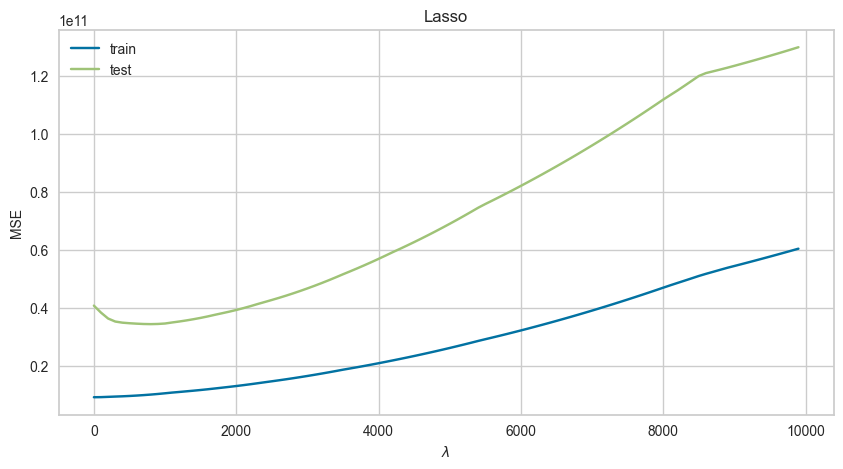

In [17]:
lambdas = np.arange(0, 10000, step=100)

lasso_train, lasso_test = evaluate_model(Lasso, lambdas)
plot_errors(lambdas, lasso_train, lasso_test, "Lasso")

A parameter with a value under 1000 could allow to minimise the test error. 

In [18]:
# Perform grid search
regressor = Lasso()
# Grid of values to be tested
params = {
    'alpha': np.arange(0, 1000, step = 1) # 0 corresponds to no regularization
}
lasso_gridsearch = GridSearchCV(regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
lasso_gridsearch.fit(X_train, Y_train)
print("Best hyperparameter : ", lasso_gridsearch.best_params_)

lasso_best = lasso_gridsearch.best_estimator_

Y_train_pred = lasso_best.predict(X_train)
Y_test_pred = lasso_best.predict(X_test)

Best hyperparameter :  {'alpha': 219}


In [19]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9774649213414598
R2 score on test set :  0.9277932776093136


Lasso performances (indicated with the R2) are excellent both in Train and Test samples. Les performances en termes de R² sont excellentes en Training et en Test.

## 3.2. Regularization : Ridge

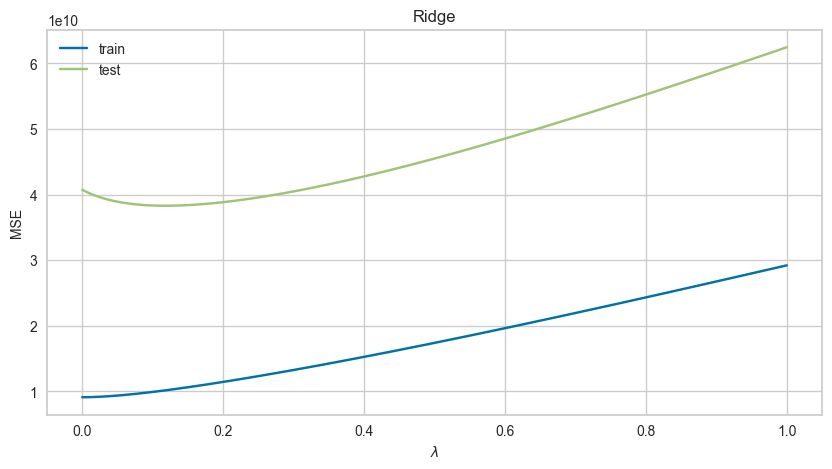

In [20]:
lambdas = np.arange(0, 1, step=0.0001)

ridge_train, ridge_test = evaluate_model(Ridge, lambdas)
plot_errors(lambdas, ridge_train, ridge_test, "Ridge")

A parameter with a value under 0.2 seems to be the most adequate. 

In [21]:
# Perform grid search
regressor = Ridge()
# Grid of values to be tested
params = {
    'alpha': np.arange(0, 0.2, step = 0.001) # 0 corresponds to no regularization
}
ridge_gridsearch = GridSearchCV(regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
ridge_gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", ridge_gridsearch.best_params_)

ridge_best = ridge_gridsearch.best_estimator_

Y_train_pred = ridge_best.predict(X_train)
Y_test_pred = ridge_best.predict(X_test)

Best hyperparameters :  {'alpha': 0.002}


In [22]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9778334234648693
R2 score on test set :  0.9183731627353933


Again, the performances in terms of R2 are excellent both in Train et in Test, perhaps a little under those of the Lasso Model.

## 3.3. Regularization : ElasticNet

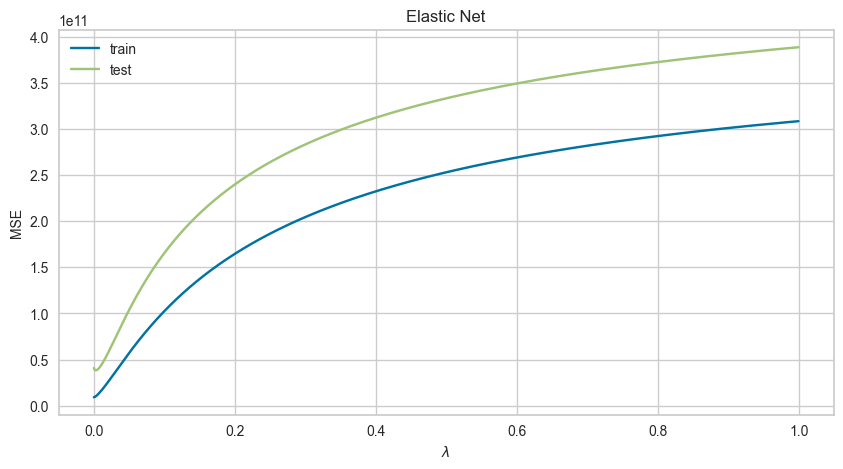

In [23]:
lambdas = np.arange(0, 1, step=0.001)

elastic_train, elastic_test = evaluate_model(ElasticNet, lambdas)
plot_errors(lambdas, elastic_train, elastic_test, "Elastic Net")

A lambda value under 0.01 seems the most appropriate for the best compromise between train and test performances. 

In [24]:
# Perform grid search
regressor = ElasticNet()
# Grid of values to be tested
params = {
    "max_iter": [1000],
    "alpha": np.arange(0, 0.01, step = 0.00005),
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}
elastic_gridsearch = GridSearchCV(regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
elastic_gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", elastic_gridsearch.best_params_)

elastic_best = elastic_gridsearch.best_estimator_

Y_train_pred = elastic_best.predict(X_train)
Y_test_pred = elastic_best.predict(X_test)

Best hyperparameters :  {'alpha': 0.0002, 'l1_ratio': 0.9, 'max_iter': 1000}


In [25]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9778337795783685
R2 score on test set :  0.9183400323834184


Again we obtain very impressive performances but slightly under those of Lasso. 

## 3.4. Bilan 

In [26]:
classifier = []
for model in [model_base, lasso_best, ridge_best, elastic_best]:
  model.fit(X_train, Y_train)
  Y_train_pred    = model.predict(X_train)
  Y_test_pred     = model.predict(X_test)

  r2_train  = r2_score(Y_train, Y_train_pred)
  r2_test   = r2_score(Y_test, Y_test_pred)

  mae_train = round(mean_absolute_error(Y_train, Y_train_pred), 2)
  mae_test  = round(mean_absolute_error(Y_test, Y_test_pred), 2) 
  
  rmse_train = round(np.sqrt(mean_squared_error(Y_train, Y_train_pred)), 2)
  rmse_test = round(np.sqrt(mean_squared_error(Y_test, Y_test_pred)), 2)

  classifier.append({'Model'     : model,
                     'r2_train'  : r2_train,
                     'r2_test'   : r2_test,
                     'mae_train' : mae_train,
                     'mae_test'  : mae_test,
                     'rmse_train': rmse_train,
                     'rmse_test' : rmse_test
                     }
                    )

pd.DataFrame.from_dict(classifier).sort_values(by='r2_test', ascending=False).reset_index().drop(columns=['index'])

,Model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,Lasso(alpha=219),0.977465,0.927793,74769.70,146258.90,96257.07,189553.25
1,Ridge(alpha=0.002),0.977833,0.918373,73132.59,159253.66,95466.81,201538.90
2,"ElasticNet(alpha=0.0002, l1_ratio=0.9)",0.977834,0.918340,73124.44,159289.35,95466.04,201579.80
3,LinearRegression(),0.977835,0.918149,73077.81,159493.29,95464.03,201816.06


In terms of model performance, Lasso does the best job, considering all the indicators. 

In [27]:
labels = ["Regression", "Lasso", "Ridge", "ElasticNet"]
models = [model_base, lasso_best, ridge_best, elastic_best]
for i in range(4):
  cv = KFold(n_splits = 10, random_state = 1, shuffle = True)
  scores = cross_val_score(models[i], X_train, Y_train, scoring='r2', cv = cv, n_jobs = 1)
  print("R2 Train - "  + labels[i] + " : mean = %0.2f (SD =  %0.2f)" % (scores.mean(), scores.std()))
  scores = cross_val_score(models[i], X_test, Y_test, scoring='r2', cv = cv, n_jobs = 1)
  print("R2 Test - "  + labels[i] + " : mean = %0.2f (SD =  %0.2f)" % (scores.mean(), scores.std()))

R2 Train - Regression : mean = 0.77 (SD =  0.25)
R2 Test - Regression : mean = -3.93 (SD =  12.86)
R2 Train - Lasso : mean = 0.79 (SD =  0.22)
R2 Test - Lasso : mean = -0.60 (SD =  3.36)
R2 Train - Ridge : mean = 0.77 (SD =  0.25)
R2 Test - Ridge : mean = -2.36 (SD =  8.00)
R2 Train - ElasticNet : mean = 0.77 (SD =  0.25)
R2 Test - ElasticNet : mean = -1.56 (SD =  5.42)


In terms of variance of the performance, we observe that in a cross-validation process, the Lasso model lead to a mean R2 quite similar to the other models but with a standard deviation (variance) very low compared to the others. This in in line with a reduction of the "over-fitting", results are more stable with Lasso. 

In [28]:
for i in range(4):
  # estimate bias and variance
  mse, bias, var = bias_variance_decomp(models[i], X_train, Y_train, X_test, Y_test, loss='mse', num_rounds=200, random_seed=1)
  # summarize results
  print(labels[i] + " :")
  print('MSE: %.0f' % mse)
  print('Bias: %.0f' % bias)
  print('Variance: %.0f' % var)

Regression :
MSE: 123362836059
Bias: 50359590974
Variance: 73003245085
Lasso :
MSE: 103036850336
Bias: 46810997677
Variance: 56225852659
Ridge :
MSE: 121163595483
Bias: 50161217612
Variance: 71002377871
ElasticNet :
MSE: 121357454912
Bias: 50169659395
Variance: 71187795517


Compared to Regression, Lasso model leads to the most important decrease regarding all the indicators 

Let's finally have a look to the coefficients of the Lasso Model

In [29]:
coefs = pd.DataFrame(
    lasso_best.coef_,
    columns=["Coefficients"],
    index=pips.get_feature_names_out(),
)

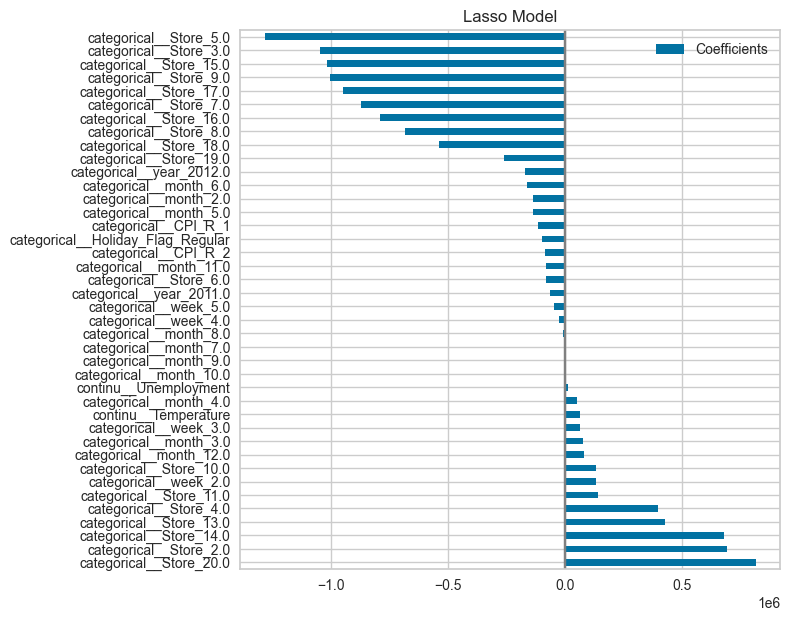

In [30]:
coefs.sort_values(by='Coefficients', ascending=False).plot(kind="barh", figsize=(9, 7))
plt.title("Lasso Model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Lasso regularization allows to simplify the model by removing some parameters (coefficients = 0) and improving the performances at the same time. Our main interpretation remains the same anyway, as the variables Store and Month are still the main explanatory factors of weekly sales.  

As a final note, let's say again that all our exploratory analyses have shown a non satisfying quality of the dataset et thus all the results have to be interpreted with caution, adding to the fact that the sample size is clearly unsufficient for this kind of modelisation. 